In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from ncon import ncon
from scipy.linalg import polar
from scipy.sparse.linalg import eigs
from scipy.sparse.linalg import eigsh

In [2]:
def W_Ising(J,g):
    #Pauli and identity matrices 
    sx = 0.5*np.array([[0,1],[1,0]])  #Pauli x
    sz = 0.5*np.array([[1,0],[0,-1]]) #Pauli z
    I = np.eye(2)                     #Identity
    
    #Constructing the MPO at one site
    W = np.zeros((3,2,3,2))
    W[0,:,0,:] = I
    W[1,:,0,:] = sz
    W[2,:,0,:] = -g*sx
    W[2,:,1,:] = -J*sz
    W[2,:,2,:] = I
    return W

In [19]:
def W_XY():
    #Spin-1/2 operators and the identity
    su = np.array([[0,1],[0,0]])  #spin up
    sd = np.array([[0,0],[1,0]])  #spin down
    I = np.eye(2)                 #Identity

    #Constructing the MPO at one site
    W = np.zeros((4,2,4,2))
    W[0,:,0,:] = I
    W[1,:,0,:] = sd
    W[2,:,0,:] = su
    W[3,:,1,:] = -0.5*su
    W[3,:,2,:] = -0.5*sd
    W[3,:,3,:] = I
    
    return W

In [20]:
def Nsite_MPO(W,Nsites):
    """""
    Inputs :
        W : MPO at one site
        Nsites : number of desired sites
    Outputs :
        MPO : The N-site MPO
    """""
    #Produce the N-site MPO
    N = Nsites - 1
    MPO = [W for l in range(Nsites)]
    
    #Construct the states on the left and right side
    D_MPO = W.shape[0] #Bond dimension of the MPO
    state_0 = np.zeros((D_MPO,1))
    state_0[0,0] = 1
    state_1 = np.zeros((D_MPO,1))
    state_1[D_MPO-1,0] = 1
    
    #Modify the left- and right-most MPO site by contracting them with our states
    MPO[0] = ncon([MPO[0],state_1.T],[[1,-1,-2,-3],[-4,1]])
    MPO[0] = MPO[0].reshape(MPO[0].shape[0],MPO[0].shape[1],MPO[0].shape[2])
    MPO[N] = ncon([MPO[N],state_0],[[-1,-2,1,-3],[1,-4]])
    MPO[N] = MPO[N].reshape(MPO[N].shape[0],MPO[N].shape[1],MPO[N].shape[2])
    
    return MPO

In [21]:
def Expectation_Value_2site_operator(U,operator) :
    """""
    Inputs :
        U : local unitary tensor
        operator : two-site operator 
    Outputs :
        Expectation_Value : Expectation value of the operator
    """""
    
    #Computing the Right Environment
    """""
    _-1_ U _-3_ __             
         |                      
         1                      
         |                   _ _1_   _3_ _
         |                =  _ _2_ M _4_ _
         |                      
         1                      
         |                      
    _-2_ Uh _-4_ _             
    """""
    
    Uh = np.conj(U)
    
    #Compute the transfer matrix
    M = ncon([U,Uh],[[-1,1,-3],[-2,1,-4]])
    E = M.reshape(M.shape[0]*M.shape[1],M.shape[2]*M.shape[3])
    
    #Solve the fixed-point equation
    eigenvalue, eigenvector = eigs(E,k=1,which="LM")
    
    #Determine R
    R = eigenvector.reshape(M.shape[0],M.shape[1])
    R = R/np.trace(R) #Trace normalised
    
    #Find the Expectation value
    """""
     _ _ _1_ U _3_ _ _3_ U _5_ _ _        
    |        |           |        |    
    |        2           4        |
    |        |           |        |  
    |        2           4        5    
    |        |           |        |             
    |        OOOOOOOOOOOOO        R           
    |        |           |        |   
    |        6           8        9              
    |        |           |        |             
    |        6           8        |              
    |        |           |        |   
    |_ _ _1_ Uh _7__ _7_ Uh _9__ _|     
    """"" 
    
    Expectation_Value = ncon([U,Uh,U,Uh,operator,R],\
                            [[1,2,3],[1,6,7],[3,4,5],[7,8,9],[2,6,4,8],[5,9]])
    
    return Expectation_Value

In [22]:
def Eigenvalue_Equation_Optimizer(W, L, R, alpha):
    """""
    Inputs :
        W : MPO at one site
        L : MPO left environment
        R : MPO right environment
        alpha : value used for spectrum shift
    Outputs :
        U_opt : Optimised tensor
    """""
    D_MPS = L.shape[0]
    d = W.shape[1]
    
    #Contract into a matrix E
    E = ncon([L,R,W],[[-1,1,-4],[-3,2,-6],[1,-2,2,-5]])
    E = E.reshape(D_MPS*d*D_MPS,D_MPS*d*D_MPS)
    
    #Spectrum shift
    E = E + alpha*np.eye(D_MPS*d*D_MPS)
    
    #Solve eigenvalue equation for eigenvector with lowest eigenvalue
    _ , vec = eigsh(E, k=1, which="LM")
    vec = vec.reshape(D_MPS*d,D_MPS)
    
    #Polar decomposition to ensure U is Unitary
    U_opt, _ = polar(vec)
    _,S,_ = np.linalg.svd(vec)
    U_opt = U_opt.reshape(D_MPS,d,D_MPS)
    
    return U_opt

In [23]:
def DMRG_1site_eigensolver(Nsites,W,D_MPS,alpha) :
    """""
    Inputs :
        Nsites : Number of sites of the MPS (also the number of iteration)
        W : MPO at one site
        D_MPS : Desired bond dimension of translationnary invariant state
        alpha : value used for spectrum shift
    Outputs :
        Energy : Array composed of the energy of the ground state after each iteration
        U : Array composed of the translationnary invariant state after each iteration
    """""
    Energy = [] #Array recording the energy after each iteration
    d = W.shape[1] #physical index
    D_MPO = W.shape[0] #bond dimension of the MPO
    N = Nsites - 1
    U = [0 for x in range(N)] #Array recording our optimised state after each iteration
    MPO = Nsite_MPO(W,Nsites) #Building the N-site MPO from W
   
    operator = ncon([MPO[0],MPO[N]],[[-1,1,-2],[1,-3,-4]]) #Operator used in our Expectation Value function
    
    A_0 = np.random.rand(d,D_MPS) #Initial random tensor used to set the bond dimension of the MPS
    
    #First optimisation 
    #Contract into a matrix E
    E_0 = ncon([MPO[0],A_0,np.conj(A_0),MPO[N]],[[1,2,3],[1,-1],[3,-3],[2,-2,-4]])
    E = E_0.reshape(E_0.shape[0]*E_0.shape[1],E_0.shape[2]*E_0.shape[3])
    #Solve eigenvalue equation for eigenvector with lowest eigenvalue
    val,vec = eigsh(E, k=1, which='LM')
    vec = vec.reshape(E_0.shape[0],E_0.shape[1])
    #Polar decomposition to ensure U is Unitary
    U_0,S,V_0 = np.linalg.svd(vec, full_matrices = False)
    U[0] = ncon([U_0,V_0],[[-1,1],[1,-2]])
    
    #Building the Left end Right environment
    L = ncon([A_0,np.conj(A_0),MPO[0]],[[1,-1],[2,-3],[1,-2,2]])
    R = ncon([U[0],np.conj(U[0]),MPO[N]],[[-1,1],[-3,2],[-2,1,2]])
    
    #n-th optimisation
    i = 1
    while i < N :
        #Contracting to the left
        U[i] = Eigenvalue_Equation_Optimizer(MPO[i], L, R, alpha)
        #Recording the energy
        Energy.append(Expectation_Value_2site_operator(U[i], operator))
        #Updating the left environment
        L = ncon([L,U[i],np.conj(U[i]),MPO[i]],[[1,2,3],[1,4,-1],[3,5,-3],[2,4,-2,5]])
        i = i + 1
        
        
        #Contracting to the right
        U[i] = Eigenvalue_Equation_Optimizer(MPO[i], L, R, alpha)
        #Recording the energy
        Energy.append(Expectation_Value_2site_operator(U[i], operator))
        #Updating the right environment
        R = ncon([R,U[i],np.conj(U[i]),MPO[i]],[[1,2,3],[-1,4,1],[-3,5,3],[-2,4,2,5]])
        i = i + 1
            
    return Energy, U

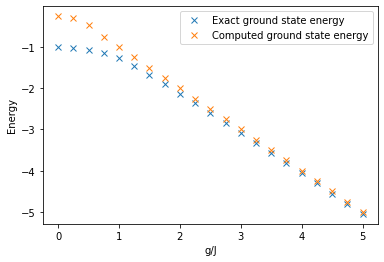

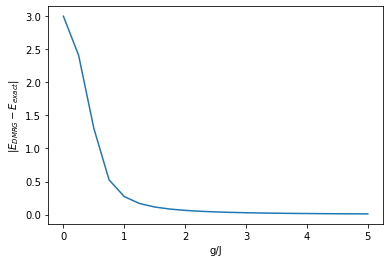

In [24]:
g = 0
J = 1
N = 5
E0 = []
E1 = []
E2 = []
while g < N + 0.25 :
    f = lambda k,g : -2*np.sqrt(1+g**2-2*g*np.cos(k))/np.pi/2.
    E0_exact = integrate.quad(f, 0, np.pi, args=(g,))[0]
    E0.append(E0_exact)
    
    E, _ = DMRG_1site_eigensolver(100,W_Ising(J,g),4,-1)
    E1.append(np.real(E[-1]))
    
    E2.append(abs((np.real(E[-1])-E0_exact)/np.real(E[-1])))
    g = g + 0.25

g = np.arange(0, N + 0.25, 0.25)
plt.plot(g, E0, "x", label = "Exact ground state energy")
plt.plot(g, E1, "x", label = "Computed ground state energy")
plt.xlabel('g/J')
plt.ylabel('Energy')
plt.legend()
plt.show()

plt.plot(g, E2)
plt.xlabel('g/J')
plt.ylabel(r'$|E_{DMRG}-E_{exact}|$')
plt.show()

-0.3122771771235577
-0.3183098861837907
0.00603270906023301


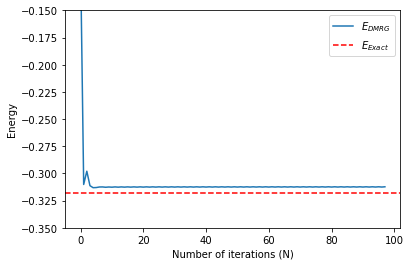

In [27]:
E2, _ = DMRG_1site_eigensolver(100,W_XY(),4,-1)
print(np.real(E2[-1]))
print(-1/np.pi)
print(abs(np.real(E2[-1])+1/np.pi))

plt.plot(E2, label = r"$E_{DMRG}$")
plt.axhline(y=-1/np.pi, color = "r", linestyle = "--", label = r"$E_{Exact}$")
plt.ylim(-0.35,-0.15)
plt.xlabel('Number of iterations (N)')
plt.ylabel('Energy')
plt.legend()
plt.show()

In [29]:
def Polar_Decomposition_Optimizer(U, W, L, R, alpha):
    """""
    Inputs :
        U : Initial guess for the optimised tensor
        W : MPO at one site
        L : MPO left environment
        R : MPO right environment
        alpha : value used for spectrum shift
    Outputs :
        U_opt : Optimised tensor
    """""
    state_0 = np.zeros((2,1))
    state_0[0,0] = 1
    D_MPS = U.shape[0]
    d = U.shape[1]
    U_old = U
    
    for i in range(1, 2000):
        #M = ncon([L,np.conj(U_old),R,W, state_0],[[1,2,-1],[1,3,4],[4,5,-3],[2,3,5,-2],[-4,-5]])
        M = ncon([L,U_old,R,W, state_0],[[1,2,-1],[1,3,4],[4,5,-3],[2,3,5,-2],[-4,-5]])
        M = M.reshape(D_MPS*d,D_MPS*d)
        M = M + alpha*np.eye(d*D_MPS)
        
        U_opt, _ = polar(M)
        U_opt = U_opt.reshape(D_MPS,d,D_MPS,d)
        U_opt = ncon([U_opt, state_0],[[-1,1,-3,-2],[1,-4]])
        U_opt = U_opt.reshape(D_MPS,d,D_MPS)
        
        if np.allclose(U_opt,U_old) == True :
            np.allclose(ncon([U_opt,U_old],[[1,2,-1],[1,2,-2]]),np.eye(D_MPS))
            break
        else :
            U_old = U_opt
    return U_opt

In [30]:
def DMRG_1site_polar(Nsites,W,D_MPS,alpha) :
    """""
    Inputs :
        Nsites : Number of sites of the MPS (also the number of iteration)
        W : MPO at one site
        D_MPS : Desired bond dimension of translationnary invariant state
        alpha : value used for spectrum shift
    Outputs :
        Energy : Array composed of the energy of the ground state after each iteration
        U : Array composed of the translationnary invariant state after each iteration
    """""
    Energy = [] #Array recording the energy after each iteration
    d = W.shape[1] #physical index
    D_MPO = W.shape[0] #bond dimension of the MPO
    N = Nsites - 1
    U = [0 for x in range(N)] #Array recording our optimised state after each iteration
    MPO = Nsite_MPO(W,Nsites) #Building the N-site MPO from W
    
    operator = ncon([MPO[0],MPO[N]],[[-1,1,-2],[1,-3,-4]]) #Operator used in our Expectation Value function
    
    #Initial random tensor used to set the bond dimension of the MPS
    A_0 = np.random.rand(d,D_MPS)
    
    #First optimisation 
    #Contract into a matrix E
    E_0 = ncon([MPO[0],A_0,np.conj(A_0),MPO[N]],[[1,2,3],[1,-1],[3,-3],[2,-2,-4]])
    E = E_0.reshape(E_0.shape[0]*E_0.shape[1],E_0.shape[2]*E_0.shape[3])
    #Solve eigenvalue equation for eigenvector with lowest eigenvalue
    val,vec = eigsh(E, k=1, which='LM')
    vec = vec.reshape(E_0.shape[0],E_0.shape[1])
    #Polar decomposition to ensure U is Unitary
    U_0,S,V_0 = np.linalg.svd(vec, full_matrices = False)
    U[0] = ncon([U_0,V_0],[[-1,1],[1,-2]])
    
    #Building the Left end Right environment
    L = ncon([A_0,np.conj(A_0),MPO[0]],[[1,-1],[2,-3],[1,-2,2]])
    R = ncon([U[0],np.conj(U[0]),MPO[N]],[[-1,1],[-3,2],[-2,1,2]])
    
    #n-th optimisation
    i = 1
    U[i-1] = np.random.rand(D_MPS,d,D_MPS)
    while i < N :
        #Contracting to the left
        U[i] = Polar_Decomposition_Optimizer(U[i-1], MPO[i], L, R, alpha)
        #Recording the energy
        Energy.append(Expectation_Value_2site_operator(U[i], operator))
        #Updating the left environment
        L = ncon([L,U[i],np.conj(U[i]),MPO[i]],[[1,2,3],[1,4,-1],[3,5,-3],[2,4,-2,5]])
        i = i + 1
        
        
        #Contracting to the right
        U[i] = Polar_Decomposition_Optimizer(U[i-1], MPO[i], L, R, alpha)
        #Recording the energy
        Energy.append(Expectation_Value_2site_operator(U[i], operator))
        #Updating the right environment
        R = ncon([R,U[i],np.conj(U[i]),MPO[i]],[[1,2,3],[-1,4,1],[-3,5,3],[-2,4,2,5]])
        i = i + 1
            
    return Energy, U

-0.24820168740727505 -4.062748051411006


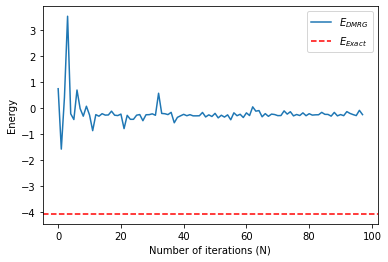

4.006273967958862e-18 -0.3183098861837907


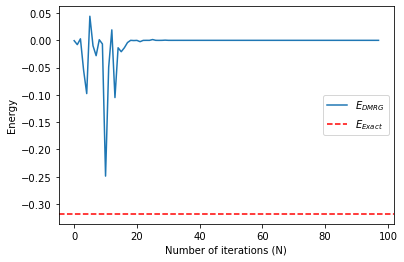

In [31]:
N = 100
g = 4
J = 1

f = lambda k,g : -2*np.sqrt(1+g**2-2*g*np.cos(k))/np.pi/2.
E0_exact_1 = integrate.quad(f, 0, np.pi, args=(g,))[0]
E0_exact_2 = -1/np.pi

E1, _ = DMRG_1site_polar(N,W_Ising(J,g),4,-1)
print(np.real(E1[-1]),E0_exact_1)

plt.plot(np.real(E1), label = r"$E_{DMRG}$")
plt.axhline(y = E0_exact_1, color='r', linestyle='--', label = r"$E_{Exact}$")
plt.xlabel('Number of iterations (N)')
plt.ylabel('Energy')
plt.legend()
plt.show()

E2, _ = DMRG_1site_polar(N,W_XY(),4,-1)
print(np.real(E2[-1]),E0_exact_2)

plt.plot(np.real(E2), label = r"$E_{DMRG}$")
plt.axhline(y = E0_exact_2, color='r', linestyle='--', label = r"$E_{Exact}$")
plt.xlabel('Number of iterations (N)')
plt.ylabel('Energy')
plt.legend()
plt.show()